In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from datetime import datetime, date
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import StandardScaler
from math import ceil

from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import RMSprop

In [5]:
train = pd.read_csv('sales_train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')
items = pd.read_csv('items.csv')
item_cats = pd.read_csv('item_categories.csv')
shops = pd.read_csv('shops.csv')

In [6]:
test_shops = test.shop_id.unique()
train = train[train.shop_id.isin(test_shops)]
test_items = test.item_id.unique()
train = train[train.item_id.isin(test_items)]

In [7]:
MAX_BLOCK_NUM = train.date_block_num.max()
MAX_ITEM = len(test_items)
MAX_CAT = len(item_cats)
MAX_YEAR = 3
MAX_MONTH = 4 # 7 8 9 10
MAX_SHOP = len(test_shops)

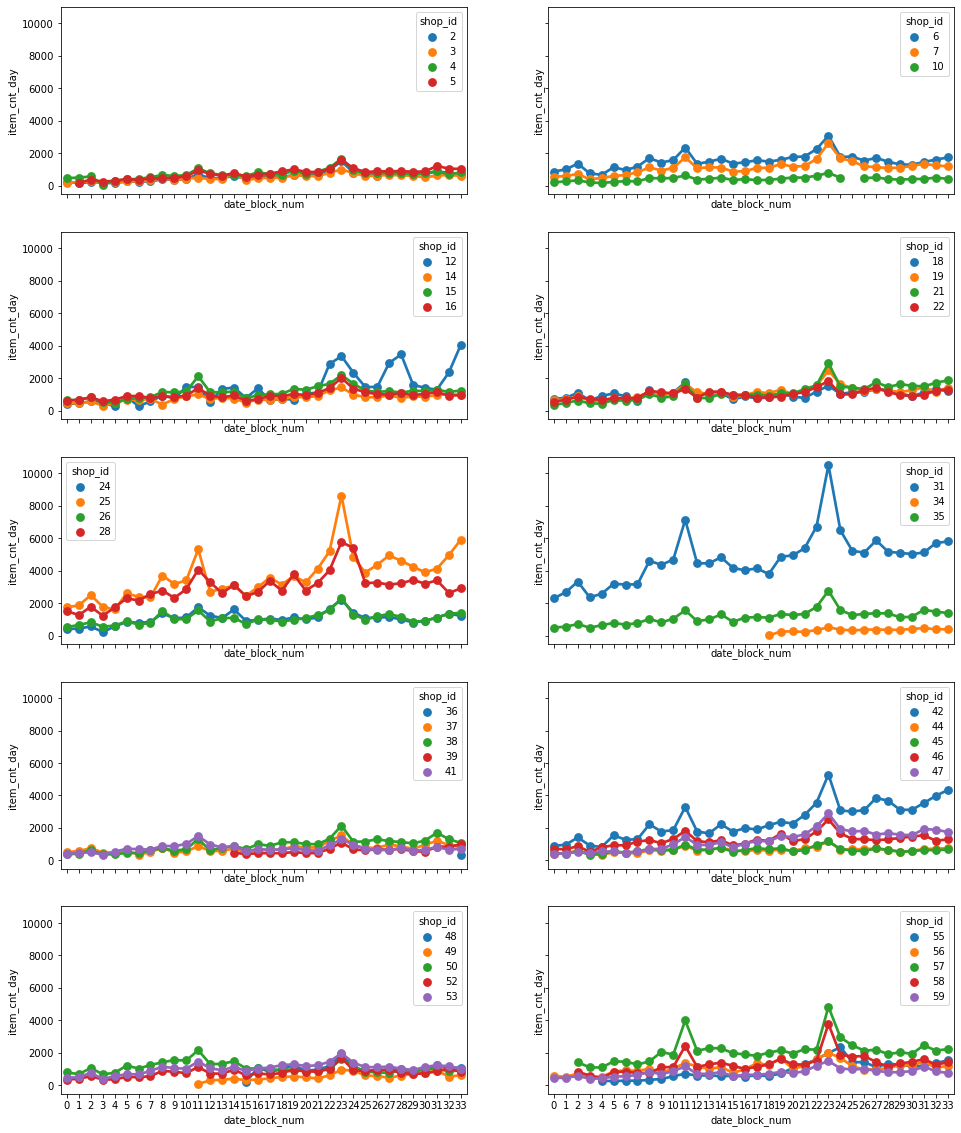

In [8]:
grouped = pd.DataFrame(train.groupby(['shop_id', 'date_block_num'])['item_cnt_day'].sum().reset_index())
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
num_graph = 10
id_per_graph = ceil(grouped.shop_id.max() / num_graph)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='date_block_num', y='item_cnt_day', hue='shop_id', data=grouped[np.logical_and(count*id_per_graph <= grouped['shop_id'], grouped['shop_id'] < (count+1)*id_per_graph)], ax=axes[i][j])
        count += 1

In [9]:
# add categories
train = train.set_index('item_id').join(items.set_index('item_id')).drop('item_name', axis=1).reset_index()

In [10]:
train['month'] = train.date.apply(lambda x: datetime.strptime(x, '%d.%m.%Y').strftime('%m'))
train['year'] = train.date.apply(lambda x: datetime.strptime(x, '%d.%m.%Y').strftime('%Y'))

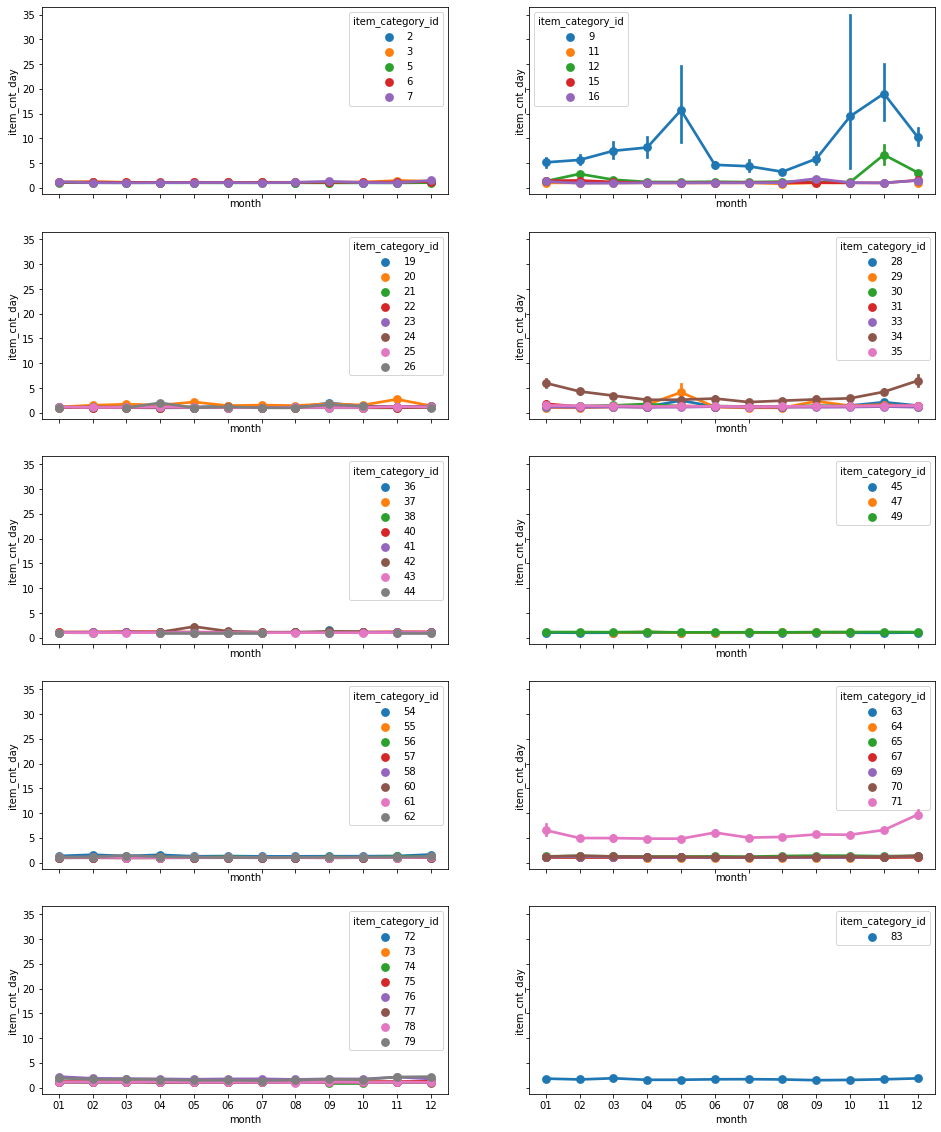

In [11]:
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
num_graph = 10
id_per_graph = ceil(train.item_category_id.max() / num_graph)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='month', y='item_cnt_day', hue='item_category_id', 
                      data=train[np.logical_and(count*id_per_graph <= train['item_category_id'], train['item_category_id'] < (count+1)*id_per_graph)], 
                      ax=axes[i][j])
        count += 1

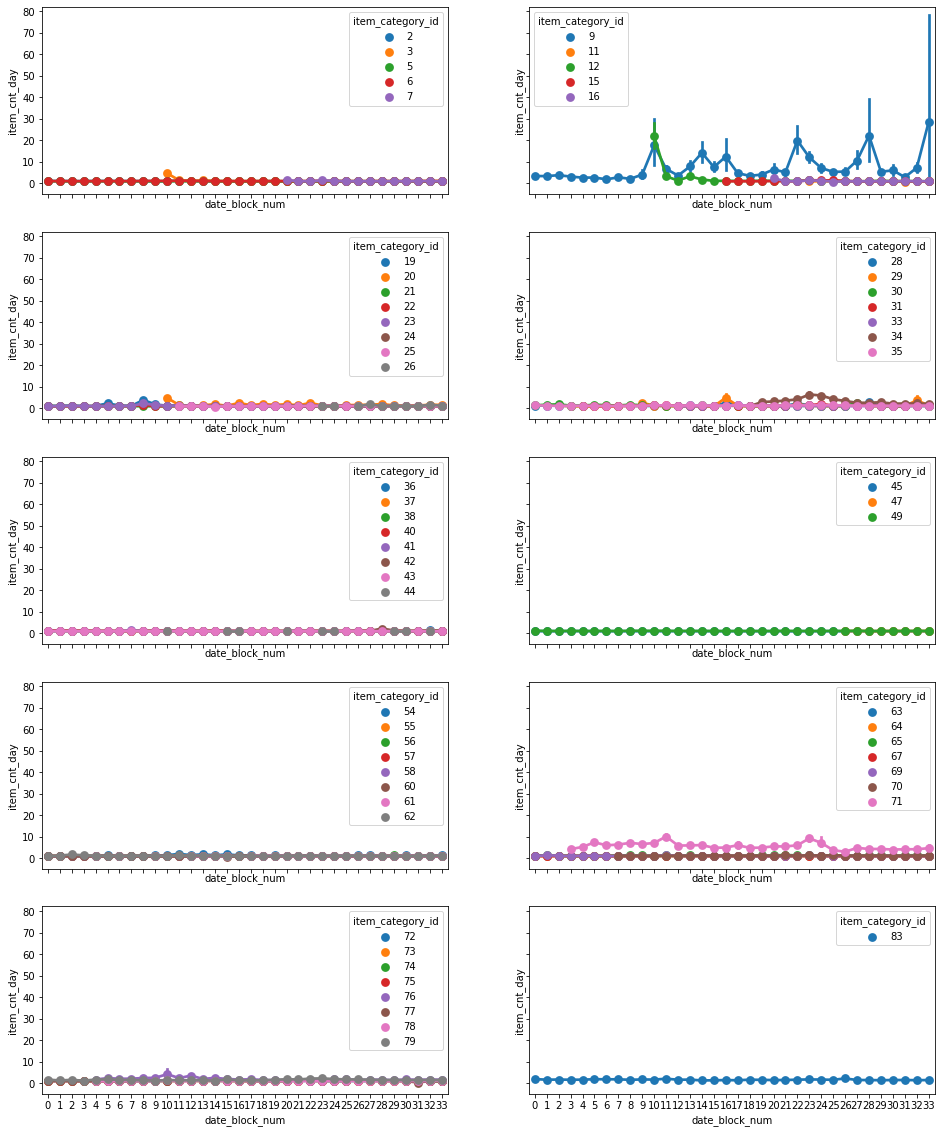

In [12]:
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
num_graph = 10
id_per_graph = ceil(train.item_category_id.max() / num_graph)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='date_block_num', y='item_cnt_day', hue='item_category_id', 
                      data=train[np.logical_and(count*id_per_graph <= train['item_category_id'], train['item_category_id'] < (count+1)*id_per_graph)], 
                      ax=axes[i][j])
        count += 1

In [13]:
train = train.drop('date', axis=1)
train = train.drop('item_category_id', axis=1)
train = train.groupby(['shop_id', 'item_id', 'date_block_num', 'month', 'year']).sum()
train = train.sort_index()

In [14]:
train.reset_index().groupby(['item_id', 'date_block_num', 'shop_id']).mean()

item_price  item_cnt_day
item_id date_block_num shop_id                           
30      1              3        1596.000000           4.0
                       4        2394.000000           7.0
                       5        1596.000000           5.0
                       6        4305.666667          28.0
                       7        3152.000000          10.0
...                                     ...           ...
22167   33             28        299.000000           1.0
                       37        299.000000           1.0
                       42        897.000000           4.0
                       47        299.000000           1.0
                       50        299.000000           1.0

[600159 rows x 2 columns]

In [15]:
price = train.reset_index().set_index(['item_id', 'shop_id', 'date_block_num'])
price = price.sort_index()

In [16]:
def convert(date_block):
    date = datetime(2013, 1, 1)
    date += relativedelta(months = date_block)
    return (date.month, date.year)

def closest_date_block(current_day, item_id, shop_id):
    """Find the block_date which is closest to the current_day, given item_id and shop_id. Returns index integer"""
    if (item_id, shop_id) in price.index:
        search_lst = np.array(price.loc[(item_id, shop_id)].index)        
        return search_lst[np.abs(current_day - search_lst).argmin()]
    return -1
                
def closest_price(current_day, item_id, shop_id):
    closest_date = closest_date_block(current_day, item_id, shop_id)
    if closest_date != -1:
        return price.loc[( item_id, shop_id, closest_date )]['item_price']
    return np.nan

def closest_price_lambda(x):
    return closest_price(34, x.item_id, x.shop_id)

In [17]:
assert closest_date_block(18, 30, 5) == 18

In [18]:
# Some simple math to know what date_block_num to start learning
print(convert(6))
print(convert(18))
print(convert(30))

(7, 2013)
(7, 2014)
(7, 2015)


In [ ]:
maxlen = 4 # 4 months
step = 1
# 0: train, 1: val, 2:test
sentences = [[],[],[]]
next_chars = [[], []]
BLOCKS = [6, 18, 30]

for s in test_shops:
    shop_items = list(train.loc[s].index.get_level_values(0).unique())
    for it in shop_items:        
        for i_index, i in enumerate(BLOCKS):
            sentence = []
            closest_pc = closest_price(i, it, s)            
            for j in range(maxlen+1):
                if j < maxlen:
                    if (s, it, i+j) in train.index:
                        r = train.loc[(s, it, i + j)].to_dict(orient='list')                    
                        closest_pc = r['item_price'][0]
                        item_cnt_day = r['item_cnt_day'][0]
                        row = {'shop_id': s, 'date_block_num': i+j, 'item_cnt_day': item_cnt_day, 
                               'month': month, 'item_id': it, 'item_price': closest_pc, 'year': year}
                    else:
                        month, year = convert(i+j)                    
                        row = {'shop_id': s, 'date_block_num': i+j, 'item_cnt_day': 0, 
                               'month': month, 'item_id': it, 'item_price': closest_pc, 'year': year}
                    sentence.append(row)
                elif i_index < 2:   # not in test set
                    next_chars[i_index].append(row)
            sentences[i_index].append(sentence)

In [ ]:
x_train_o = np.array(sentences[0])
x_val_o = np.array(sentences[1])
x_test_o = np.array(sentences[2])
y_train = np.array([x['item_cnt_day'] for x in next_chars[0]])
y_val = np.array([x['item_cnt_day'] for x in next_chars[1]])